<a name="top"><h1>2.1. Predicciones Diarias </h1> </a>

<strong>Práctica Final : TOSCOS </strong><br />
<strong>Técnicas de Predicción: Series temporales</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong>

<p>&nbsp;</p>

<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

## Estructura

[1. Introducción](#introduccion)     

[2. Importación de librerias y carga de datos](#importacion)

[3. Análisis de la Serie Temporal](#analisis)

[4. Pruebas de modelos](#modelos)
    
   - Prophet

[5. Predicción a futuro](#prediccion)
          



<hr style="border:1px solid gray">

## <a name="introduccion"> 1. Introducción </a>

Una vez realizado el análisis exploratorio del dataset de TOSCOS en `1_EDA`, nos centraremos en probar diferentes modelos y algorítmos de predicción para la serie temporal diaria, con el objetivo de seleccionar aquel que menor error tenga para predecir las ventas diarias desde el 1 de agosto de 2015 al 10 de septiembre de 2015.

## <a name="importacion"> 2. Importación de librerias y carga de datos <a>

Procedemos a cargar las librerias a utilizar:

In [3]:
# Import basic libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import models.

from prophet import Prophet

# Import metrics and utilities.
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series # Graficar series
from sktime.forecasting.model_selection import temporal_train_test_split # Dividir dataset en train y test
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Ignore warnings.

import warnings
warnings.filterwarnings('ignore')


Procedemos a importar el dataset:

In [4]:
# Read the csv file.

data = pd.read_csv('../data/datos.csv')


# Convert the date column to datetime format.

data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Separate Store  using the second and third letter into two new columns (Zone and type).

data['Zone'] = data['Store'].str[1:2]
data['Type'] = data['Store'].str[2:3]

# Sort by date.

data = data.sort_values(by='Date', ascending=True)

#Resest the index.

data.reset_index(drop=True, inplace=True)

# Display the first 5 rows.

data.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Zone,Type
0,T3d,2,2013-01-01,0,0,0,0,a,1,3,d
1,T1a,2,2013-01-01,0,0,0,0,a,1,1,a
2,T1b,2,2013-01-01,0,0,0,0,a,1,1,b
3,T1c,2,2013-01-01,0,0,0,0,a,1,1,c
4,T2a,2,2013-01-01,0,0,0,0,a,1,2,a


## <a name="analisis"> 3. Análisis de la Serie Temporal <a>

En este apartado procederemos a analizar la tendencia, estacionalidad y componente estacional de la serie temporal. Para ello agruparemos las ventas totales de las tiendas, con el objetivo de detectar las características de la serie temporal diaria.

In [5]:
# Copy data with name df.

df = pd.read_csv('../data/datos.csv')

# Group the df sales by date.

df = df.groupby('Date')['Sales'].sum().reset_index()


Observamos la representación gráfica de la serie diaria:

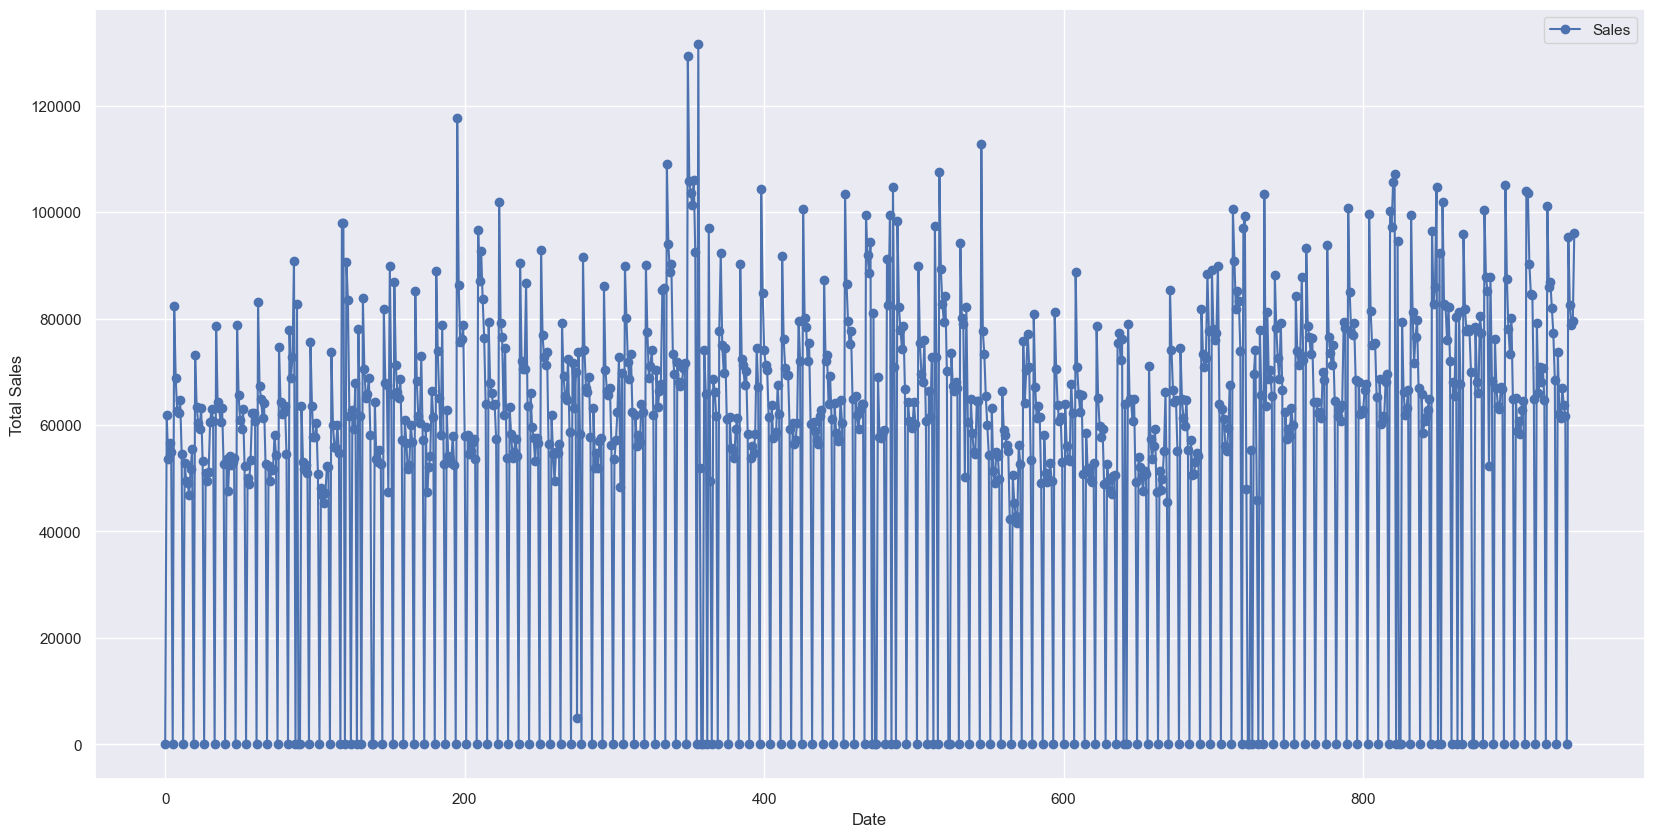

In [6]:
# Plot the sales by date.

sns.set(rc={'figure.figsize':(20, 10)})
ax = df.plot(marker='o', linestyle='-')
ax.set_ylabel('Total Sales')
ax.set_xlabel('Date')
plt.show()


Descomponemos la serie temporal:

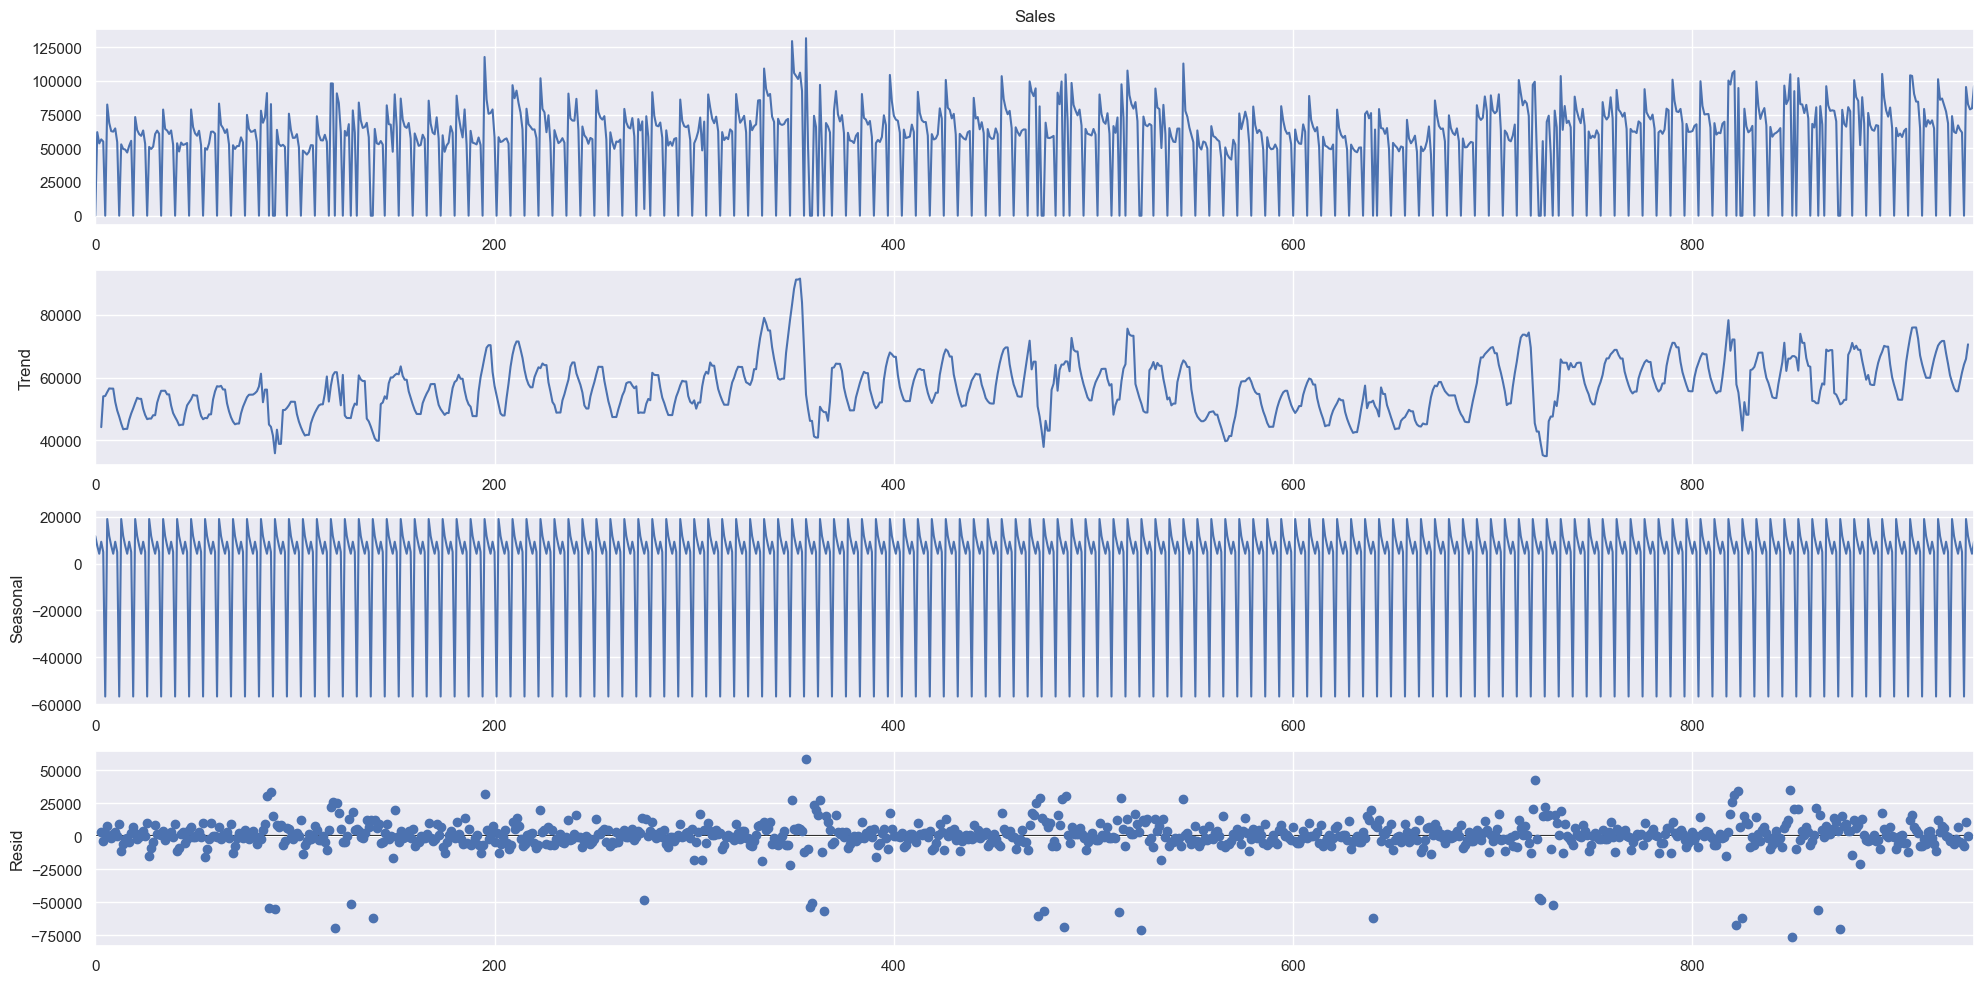

In [7]:
# Seasonal Decomposition.

result = seasonal_decompose(df['Sales'], model='additive', period=7)
result.plot()
plt.show()


Observamos como la tendencia de la serie temporal semanal se mantiene en linea, aunque ligeramente creciente al final de la serie. 
En cuanto a la estacionalidad observamos como existe un componente estacional que se va repitiendo. Sin embargo, falta por comprobar si existe estacionalidad en media y varianza dentro de la serie, para ello nos ayudaremos de Dickey-Fuller

In [13]:

# Function to test stationarity.

def test_stationarity(timeseries):

        #Perform Dickey-Fuller test:
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='BIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)

# Test stationarity.

test_stationarity(df['Sales'])



Results of Dickey-Fuller Test:
Test Statistic                  -3.964887
p-value                          0.001606
#Lags Used                      20.000000
Number of Observations Used    921.000000
Critical Value (1%)             -3.437470
Critical Value (5%)             -2.864683
Critical Value (10%)            -2.568444
dtype: float64


Observamos como una vez realizado el test de Dickey-Fuller el p-valor es menor que el nivel de significación (5%), por lo que confirmamos que nuestra serie temporal diaria es estacionaria. Sin embargo, procedemos a comprobarlo mediante las medias moviles representando las medias moviles de la serie y la desviación estandar movil.

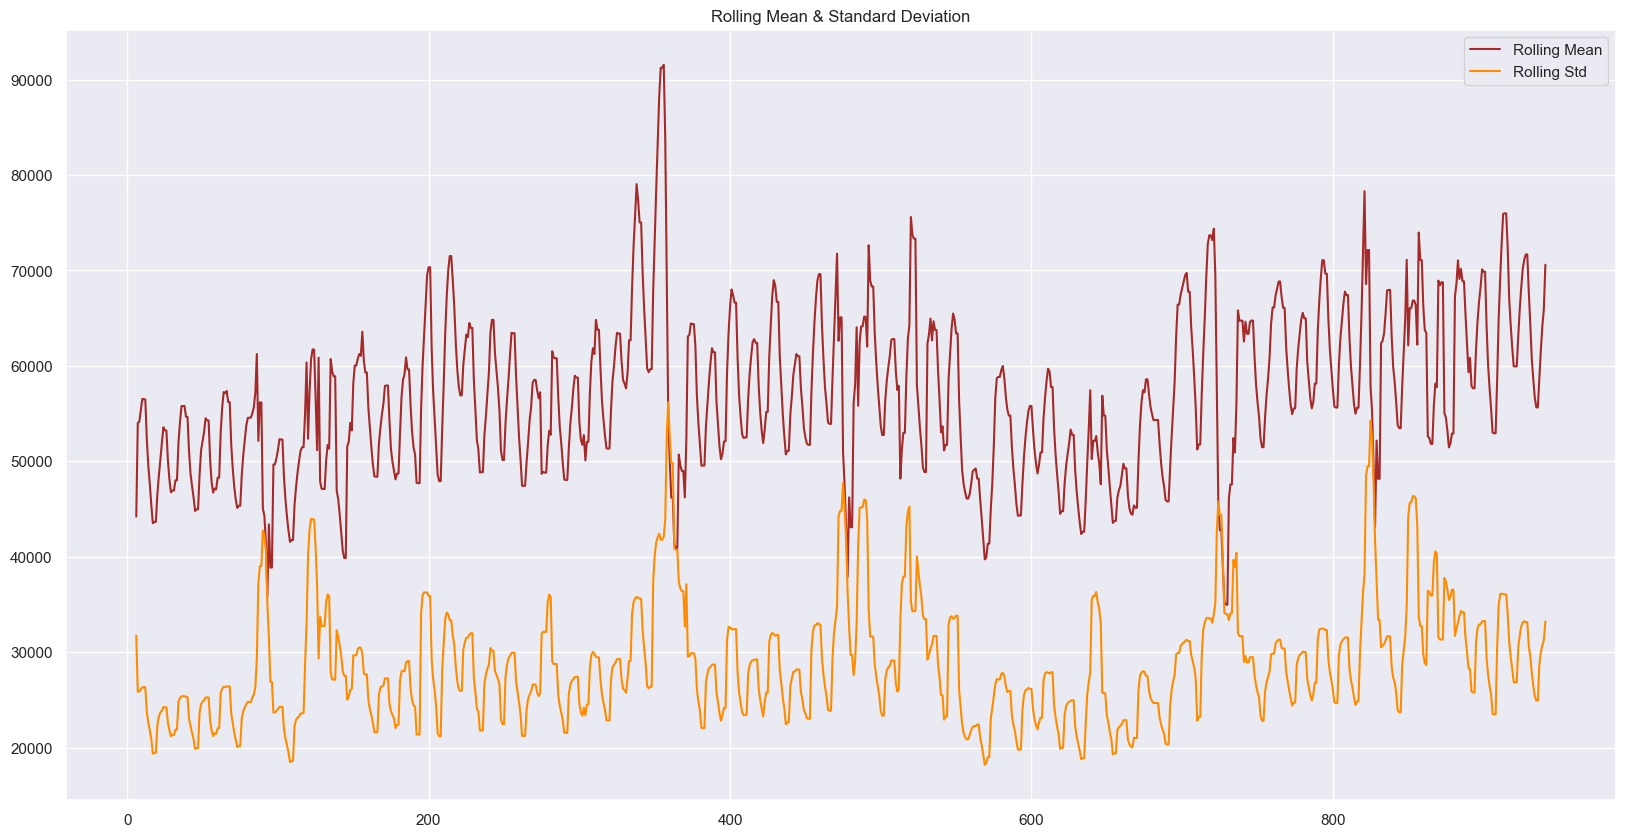

In [8]:
# Plot the rolmean and rolstd.

rolmean = df['Sales'].rolling(window=7).mean()
rolstd = df['Sales'].rolling(window=7).std()

plt.plot(rolmean, color='brown', label='Rolling Mean')
plt.plot(rolstd, color='darkorange', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()


Observamos como tanto la media movil y la desviación estandar movil se mantienen estables por lo que definitivamente confirmamos que la serie temporal es estacionaria tanto en media como en varianza.

## <a name="modelos"> 4. Pruebas de modelos <a>

En este apartado relizaremos los modelos que mejor se pueden ajustar a la serie temporal, con el objetivo de quedarnos con aquel que mejor resultado nos de para predecir las ventas desde el 1 de agosto de 2015 al 10 de septiembre de 2015. Por ello dada las características de la serie temporal, se considera que el mejor modelo a aplicar es el Prophet, dado que podemos utilizar algunas variables como regresores.

###  4.1 Modelo Prophet 

#### 4.1.1  Modelo Simple

Para realizar las predicciones con este modelo es necesario realizar una serie de transformaciones en el nombre de las variables.

In [205]:
# Data copy.

data_m = data.copy()

# For each Different Store, replace the value for a number

data_m['Store'] = data_m['Store'].astype('category')
data_m['Store'] = data_m['Store'].cat.codes

# Convert the string values of StateHoliday to 1.

data_m['StateHoliday'] = data_m['StateHoliday'].replace({'a': 1, 'b': 1, 'c': 1})

# Group the data by date and sum the sales.

data_m = data_m.groupby('Date')['Sales'].sum().reset_index()

# Rename the columns to ds and y.

data_m.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)

# Display the first row.

data_m.head(5)

,ds,y
0,2013-01-01,0
1,2013-01-02,61926
2,2013-01-03,53588
3,2013-01-04,56578
4,2013-01-05,54938


Una vez realizadas las transforamciones, comenzamos separando en train y test. Por ello seleccionaremos como train un 75% de los datos.

In [207]:
# Check the data shape

data_m.shape


# Split the data into train and test.

train = data_m.iloc[:706,:]
test = data_m.iloc[706:,:]

Procedemos a crear el modelo y obtener la métrica R² para comprobar que tal bueno es. Un valor de R² cercano a 1 indica que el modelo explica una gran proporción de la variabilidad en los datos observados, lo que indica una alta precisión del modelo. Por otro lado, un valor de R² cercano a 0 indica que el modelo no explica gran parte de la variabilidad en los datos observados, lo que indica una baja precisión del modelo.

23:59:54 - cmdstanpy - INFO - Chain [1] start processing
23:59:55 - cmdstanpy - INFO - Chain [1] done processing


0.502547054796775


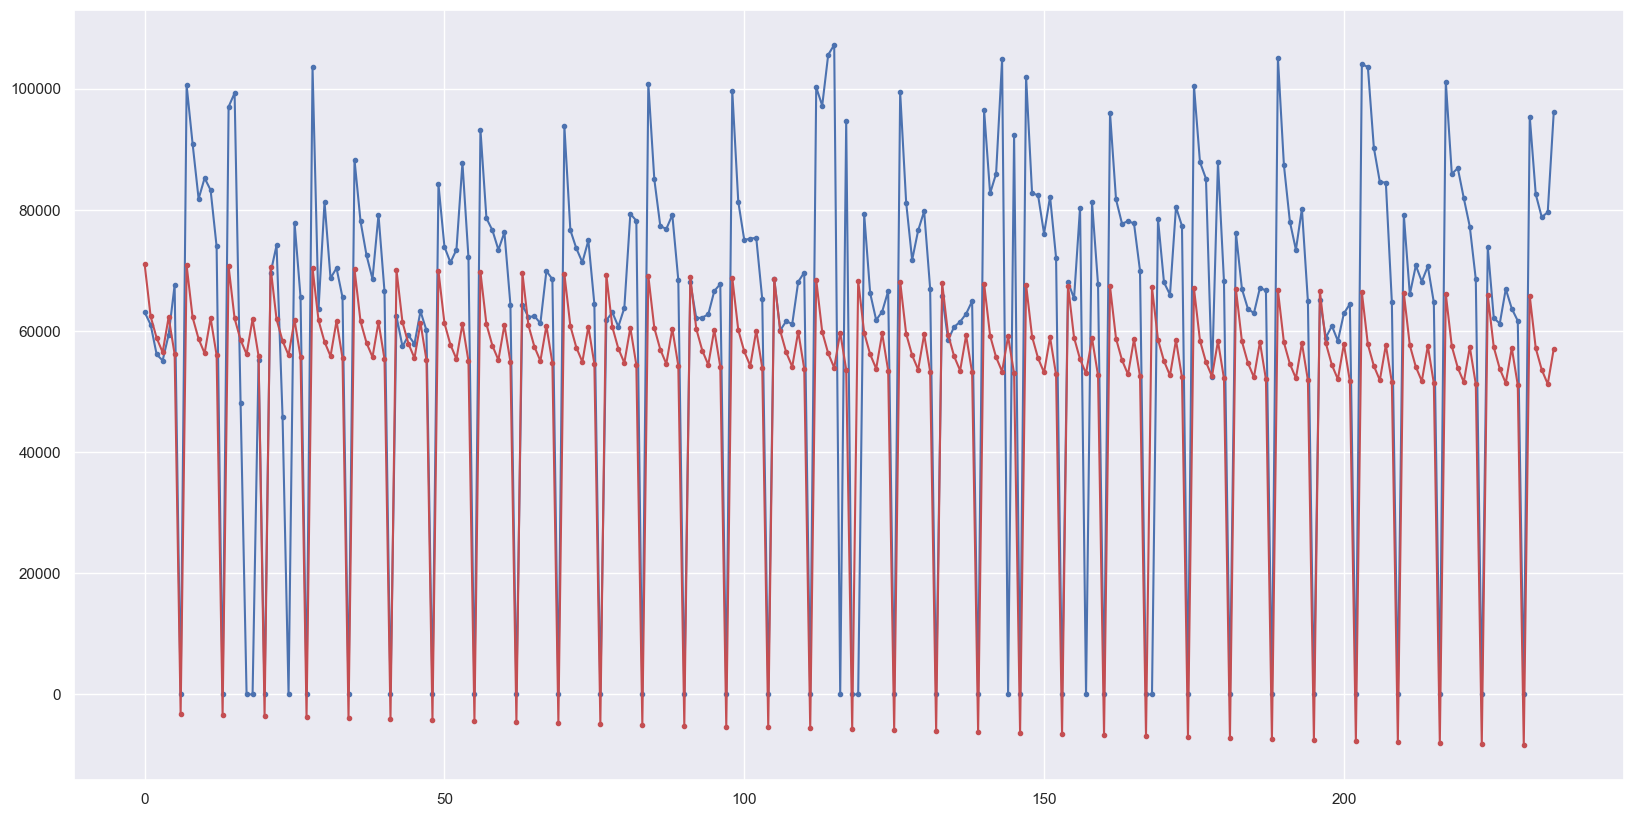

In [208]:
# Create the model

m = Prophet()

# Add the seasonality.

m.add_seasonality(name='daily', period=1, fourier_order=2)

# Fit the model.

m.fit(train)

# Create the future dataframe.

future = m.make_future_dataframe(periods=len(test))

# Predict the test period

forecast = m.predict(future)

# Print the r2 metric.

print(r2_score(list(test['y']), list(forecast.loc[706:,'yhat'] )))


#Plot the forecast compared to the actual values.
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast.loc[706:,'yhat']),'r.-')
plt.show()

Observamos que obtenemos un R² con el modelo más básico, sin embargo vamos a probar a añadir los días festivos al modelo. Para ello extraeremos los días festivos nacionales en `holidays`

#### 4.1.1  Modelo con fechas festivas

Extraemos los días festivos y los añadimos al modelo.

In [209]:
# Rename string values to 1.

stateholiday = data.replace({'StateHoliday': {'a': 1, 'b': 1, 'c': 1}})


# Rename the Date column to ds and the StateHoliday column to holiday.

stateholiday.rename(columns={'Date': 'ds', 'StateHoliday': 'holiday'}, inplace=True)

# Drop the rows where holiday is 0.

stateholiday = stateholiday[stateholiday['holiday'] == 1]

# Select only the Date column and StateHoliday column.

stateholiday = stateholiday[['ds', 'holiday']]

# Replace the values of holiday to 'holiday'

stateholiday['holiday'] = 'holiday'

stateholiday

,ds,holiday
571,2015-06-04,holiday
574,2015-06-04,holiday
577,2015-06-04,holiday
670,2015-05-25,holiday
671,2015-05-25,holiday
...,...,...
9231,2013-01-01,holiday
9232,2013-01-01,holiday
9233,2013-01-01,holiday
9234,2013-01-01,holiday


Creamos el nuevo modelo añadiendo las fechas festivas:

00:00:04 - cmdstanpy - INFO - Chain [1] start processing
00:00:04 - cmdstanpy - INFO - Chain [1] done processing


0.6022494131449013


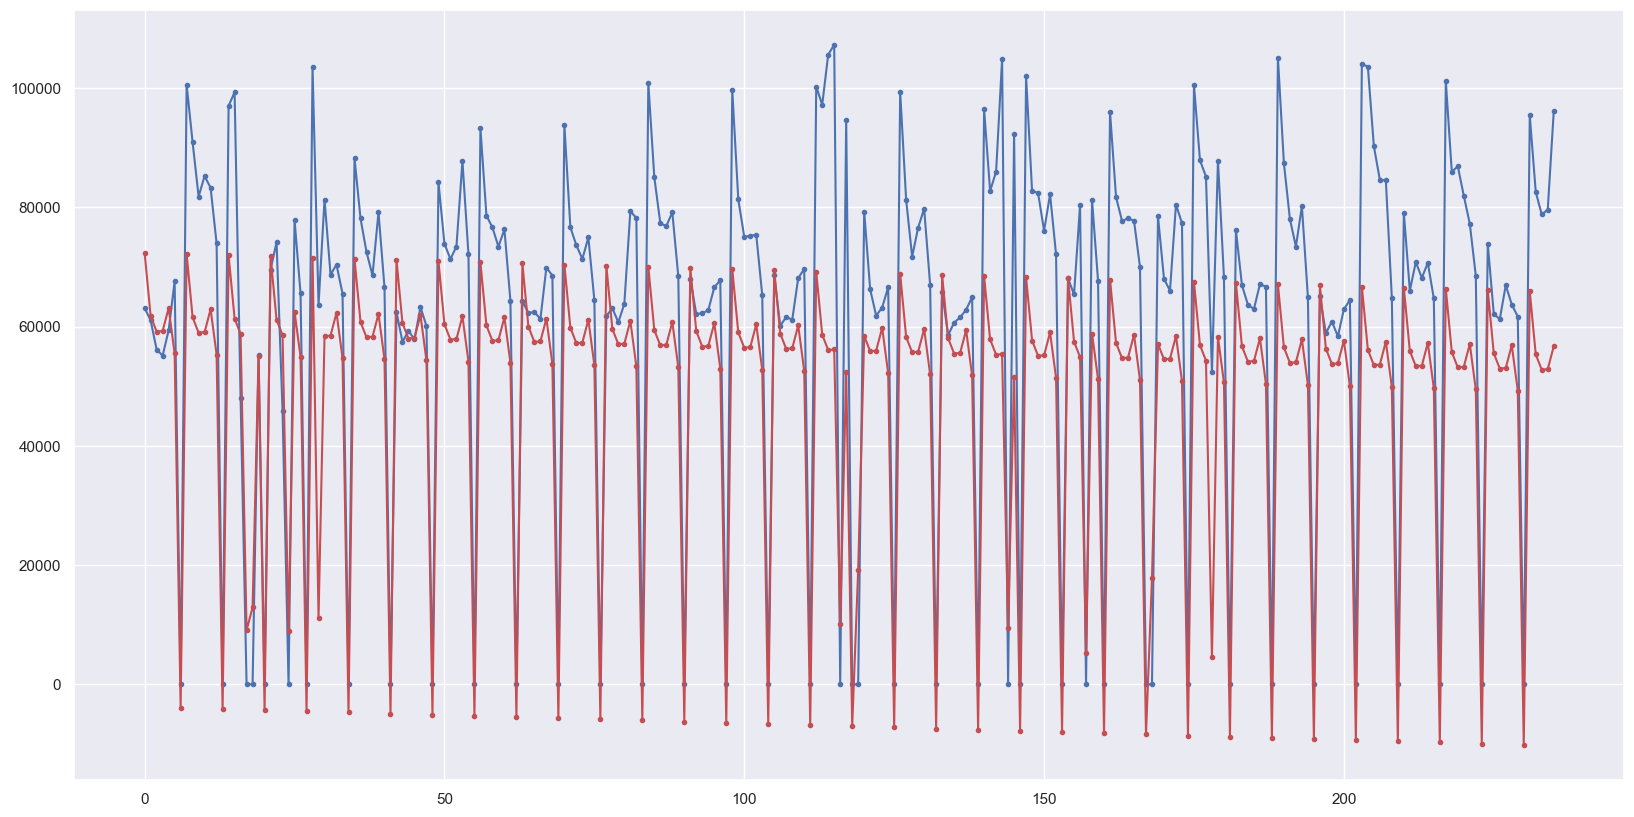

In [210]:
m1 = Prophet(holidays=stateholiday) 
m1.add_seasonality(name='daily', period=1, fourier_order=1)

# Fit the model.

m1.fit(train)

# Create the future dataframe.

future = m1.make_future_dataframe(periods=len(test))

# Predict the test period

forecast = m1.predict(future)

# Print the r2 metric.

print(r2_score(list(test['y']), list(forecast.loc[706:,'yhat'] )))


#Plot the forecast compared to the actual values.
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast.loc[706:,'yhat']),'r.-')
plt.show()

Observamos que ha mejorado un 10 %. Dado que el modelo nos permite añadir regresores, añadiremos la variable de `Customers` dada la gran correlación que tiene con el nº de ventas.

#### 4.1.3  Modelo con festivos y customers

Procedemos a probar el modelo añadiendo la variable `Customers` como regresor, y testeandolo con el valor de test. Para calcular el r2 no hay problemas dado que conocemos los datos.

In [275]:
data_m3 = data.copy()

# Rename the Date column to ds and Sales column to y.

data_m3.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)

# Select only Date, Sales and Customers columns.

data_m3 = data_m3[['ds', 'y', 'Customers']]


# Group the data by date and sum the sales.

data_m3 = data_m3.groupby('ds')['y', 'Customers'].sum().reset_index()


data_m3.head()


,ds,y,Customers
0,2013-01-01,0,0
1,2013-01-02,61926,7490
2,2013-01-03,53588,6650
3,2013-01-04,56578,6784
4,2013-01-05,54938,6747


In [276]:
# Split the data into train and test.

train = data_m3.iloc[:706,:]
test = data_m3.iloc[706:,:]

15:53:02 - cmdstanpy - INFO - Chain [1] start processing
15:53:02 - cmdstanpy - INFO - Chain [1] done processing


0.9724039690918145


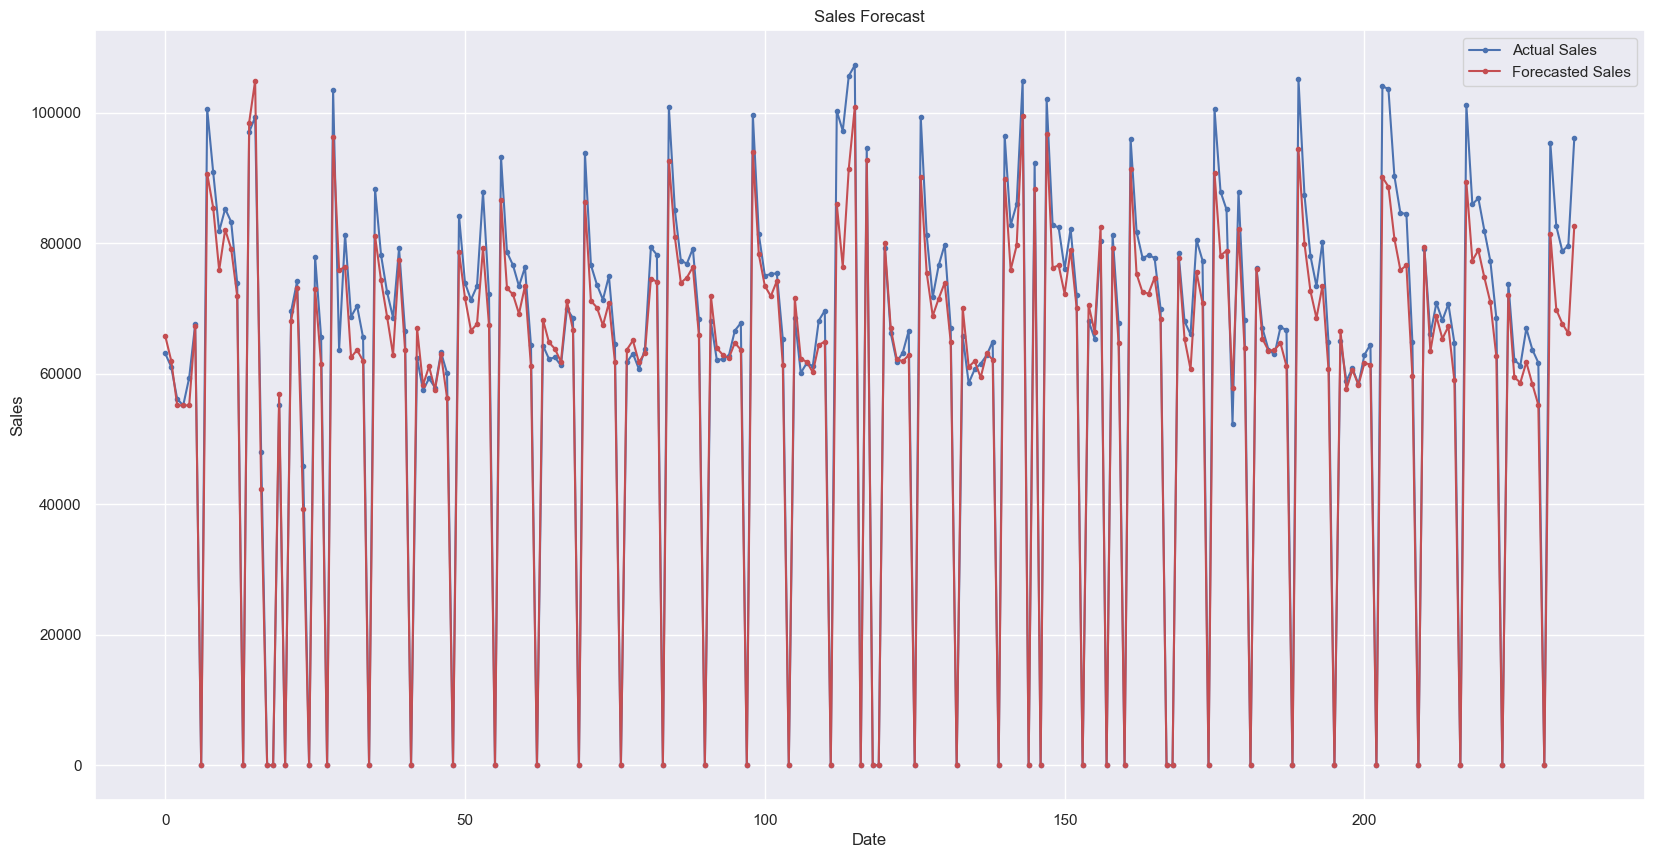

In [277]:
# Create the model.

m3 = Prophet(holidays=stateholiday) 

# Add seasonalitu.

m3.add_seasonality(name='daily', period=1, fourier_order=2)

# Add regressor.

m3.add_regressor('Customers')

# Fit the model.

m3.fit(train)

# Create the future dataframe, adding the regressors

future3 = m3.make_future_dataframe(periods=len(test))
future3['Customers'] = test['Customers']


# Fillna values of the columns Promo, Sundays and Customers with 0.

future3['Customers'].fillna(0, inplace=True)

# Predict the values.

forecast3 = m3.predict(future3)

# Limit Negative values to 0.

forecast3['yhat'] = np.where(forecast3['yhat'] < 0, 0, forecast3['yhat'])


print(r2_score(list(test['y']), list(forecast3.loc[706:,'yhat'] )))


#Plot the forecast compared to the actual values.
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast3.loc[706:,'yhat']),'r.-')
# Add labels.

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast')
plt.legend(['Actual Sales', 'Forecasted Sales'])


plt.show()

Observamos que añadiendo el nº de clientes el modelo se comporta muy biern, por lo que realizaremos un modelo aparte para ver que tal predice el nº de clientes. En el caso de que obtenga un buen resultado predeciremos el nº de clientes para poderlos añadir como regresores. 

#### 4.1.4  Predicción de customers

15:53:38 - cmdstanpy - INFO - Chain [1] start processing
15:53:39 - cmdstanpy - INFO - Chain [1] done processing


0.7871301836532095


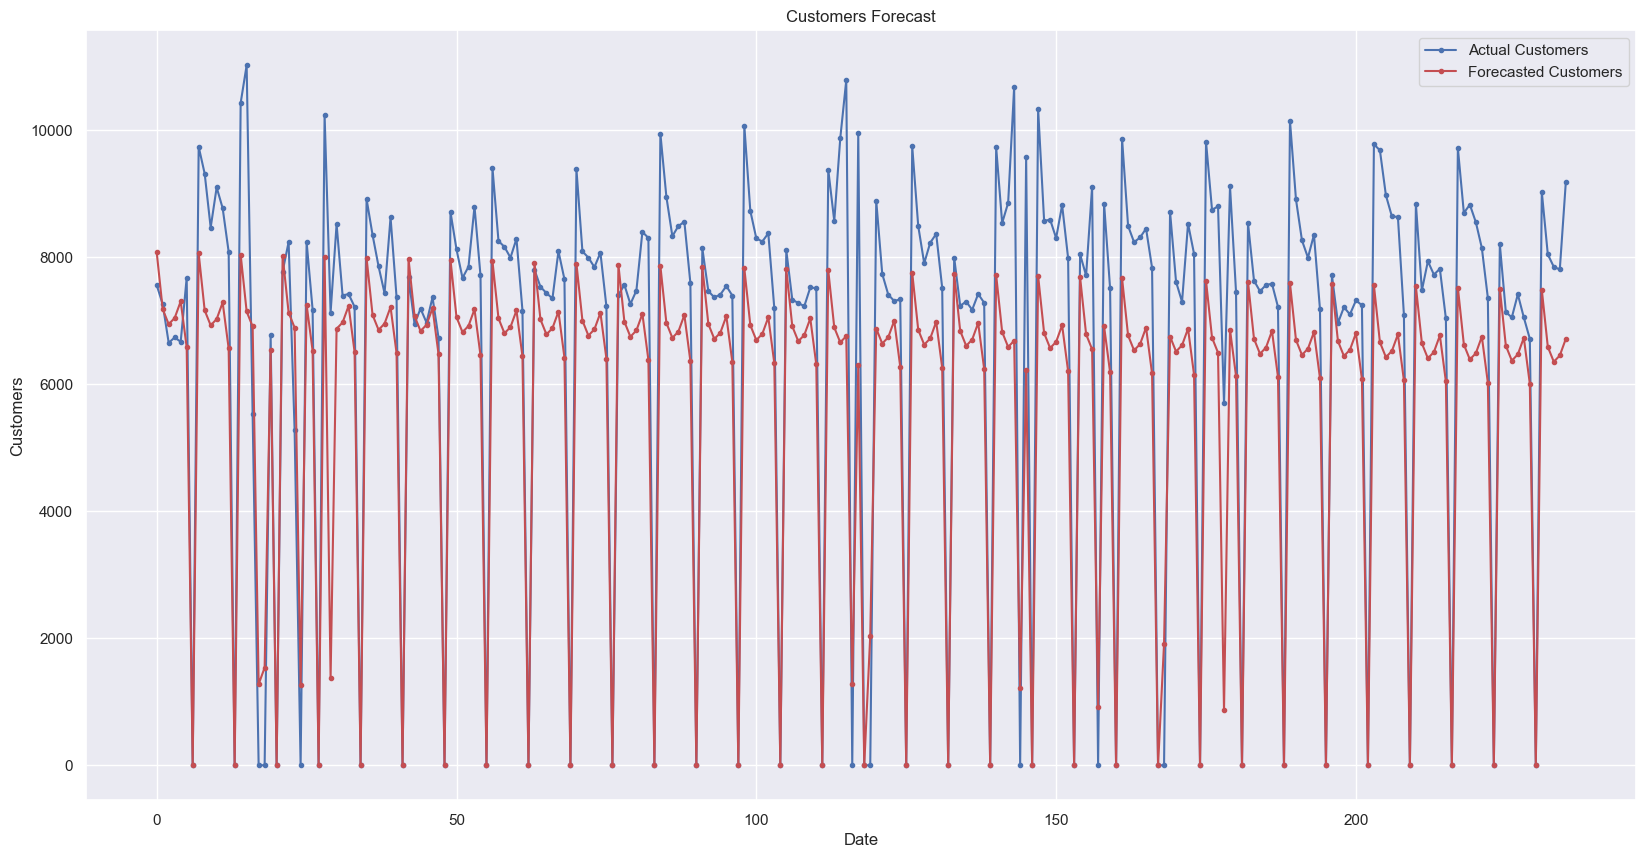

In [278]:

data_customers = data_m3.copy()

# Select ds and Customers columns.

data_customers = data_customers[['ds', 'Customers']]

# Rename the columns to ds and y.

data_customers.rename(columns={'ds': 'ds', 'Customers': 'y'}, inplace=True)

# Split the data into train and test.

train = data_customers.iloc[:706,:]

test = data_customers.iloc[706:,:]

# Create the model.

m4 = Prophet(holidays=stateholiday)

# Add seasonalitu.

m4.add_seasonality(name='daily', period=1, fourier_order=2)

# Fit the model.

m4.fit(train)

# Create the future dataframe.

future4 = m4.make_future_dataframe(periods=len(test))

# Predict the values.

forecast4 = m4.predict(future4)

# Limit Negative values to 0.

forecast4['yhat'] = np.where(forecast4['yhat'] < 0, 0, forecast4['yhat'])

print(r2_score(list(test['y']), list(forecast4.loc[706:,'yhat'] )))


#Plot the forecast compared to the actual values.

plt.plot(list(test['y']),'.-')

plt.plot(list(forecast4.loc[706:,'yhat']),'r.-')

# Add labels.

plt.xlabel('Date')

plt.ylabel('Customers')

plt.title('Customers Forecast')

plt.legend(['Actual Customers', 'Forecasted Customers'])



Vemos que ha obtenido un resultado bastante bueno, por lo que predeciremos el siguiente periodo desde 1/08/2015 hasta el 10/09/2015, es decir 41 días. COn el objetivo de añadirlo posteriormente en el modelo que prediga el nº de ventas.

In [279]:
# Create the model.

m_cust = Prophet(holidays=stateholiday)

# Add seasonalitu.

m_cust.add_seasonality(name='daily', period=1, fourier_order=2)

# Fit the model.

m_cust.fit(data_customers)

# Create the future dataframe.

future4 = m_cust.make_future_dataframe(periods=41)

# Predict the values.

forecast4 = m_cust.predict(future4)

# Limit Negative values to 0.

forecast4['yhat'] = np.where(forecast4['yhat'] < 0, 0, forecast4['yhat'])


15:53:44 - cmdstanpy - INFO - Chain [1] start processing
15:53:44 - cmdstanpy - INFO - Chain [1] done processing


In [280]:
# Select the last 41 days of the forecast of yhat and ds.

customers = forecast4.loc[942:,['ds', 'yhat']]

# Convert customers to int.

customers['yhat'] = customers['yhat'].astype(int)

# Head of the customers dataframe.

customers.head()

,ds,yhat
942,2015-08-01,7349
943,2015-08-02,282
944,2015-08-03,8884
945,2015-08-04,8122
946,2015-08-05,7860


## <a name="prediccion"> 5. Predicción a futuro<a>

Una vez pronosticados los clientes procedemos a predecir a futuro las ventas.

15:53:58 - cmdstanpy - INFO - Chain [1] start processing
15:53:59 - cmdstanpy - INFO - Chain [1] done processing


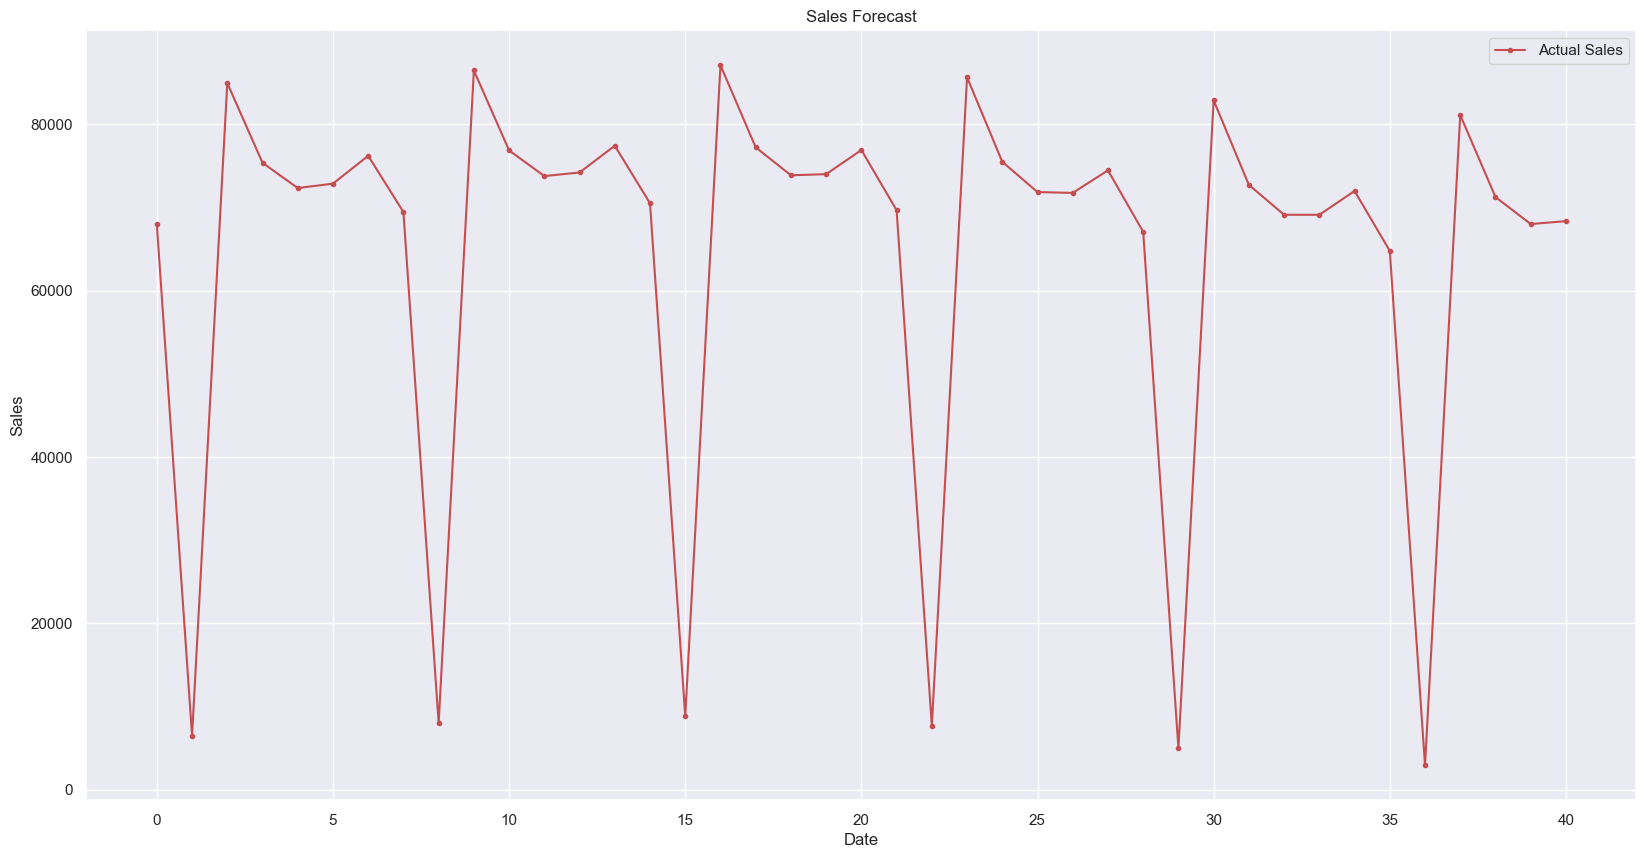

In [281]:
# Create the model.

m_future = Prophet(holidays=stateholiday) 

# Add seasonalitu.

m_future.add_seasonality(name='daily', period=1, fourier_order=2)

# Add regressor.

m_future.add_regressor('Customers')

# Fit the model.

m_future.fit(data_m3)

# Create the future dataframe, adding the regressors

future = m_future.make_future_dataframe(periods=41)
future['Customers'] = customers['yhat']


# Fillna values of the columns Promo, Sundays and Customers with 0.

future['Customers'].fillna(0, inplace=True)

# Predict the values.

final_forecast = m_future.predict(future)

# Limit Negative values to 0.

final_forecast['yhat'] = np.where(final_forecast['yhat'] < 0, 0, final_forecast['yhat'])


plt.plot(list(final_forecast.loc[942:,'yhat']),'r.-')

# Add labels.

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast')
plt.legend(['Actual Sales', 'Forecasted Sales'])


plt.show()

Una vez predecido el nº de ventas, escogemos el periodo que nos interesa y los exportamos en csv.

In [282]:
# Select the last 41 days of the forecast of yhat and ds.

sales_forecast = final_forecast.loc[942:,['ds', 'yhat']]

# Convert customers to int.

sales_forecast['yhat'] = sales_forecast['yhat'].astype(int)

# Head of the customers dataframe.

sales_forecast.head()


,ds,yhat
942,2015-08-01,67992
943,2015-08-02,6460
944,2015-08-03,84974
945,2015-08-04,75385
946,2015-08-05,72348


In [283]:
# Select yhat.

sales = sales_forecast['yhat']

# Export sales_forecast to csv.

sales.to_csv('daily_sales.csv', index=False)